# Store Item Demand Forecasting - Model Training
This is the second notebook on this project where I'll be running a data modeling process on the product sales dataset available at the Kaggle's *Store Item Demand Forecasting Challende*.

Here I'll be training Facebook's Prophet different models at scale, to cover all the products and stores.

<img src="https://i.ibb.co/FDsQbZX/kaggle-comp-banner.png" width="900" />

**Challenge Description**: <br>

<i>
This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset.

You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

What's the best way to deal with seasonality? Should stores be modeled separately, or can you pool them together? Does deep learning work better than ARIMA? Can either beat xgboost?

This is a great competition to explore different models and improve your skills in forecasting.
</i>

**Challenge Goal**: <br>

<i>
The objective of this competition is to predict 3 months of item-level sales data at different store locations. (with no holiday effect)
</i>

**Author**: Arthur G.

## Loading Dependencies
Here I'll be loading and setting up the dependencies for this notebook.

In [1]:
# add custom functions
import sys
sys.path.append('../')

# add libs
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from fbprophet import Prophet
import matplotlib.pyplot as plt
from fbprophet.serialize import model_to_json
from src.visualization.visualize import model_performance_indicators

# setting up libs
warnings.filterwarnings('ignore')
seed = np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)
plt.style.use('ggplot')
plt.rc('font', **{'family': 'DejaVu Sans', 'size': 22})

## Loading Data
Now it's time to load the dataset.

In [2]:
sales_df = pd.read_csv(os.path.join('..', 'data', 'raw', 'train.csv'))
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


## Data Preparation
Here I'll be preparing the data for the modeling-at-scale process. Let's start by grouping at store_item level.

In [3]:
# adjusting column names to match Prophet requirements
sales_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# grouping data
modeling_groups = sales_df.groupby(['store', 'item'])
modeling_groups_keys = list(modeling_groups.groups.keys())

## Training at Scale
Let's start our training process. At the end of this section we'll have a total of 500 trained models serialized as JSON files in the `models` folder. We also gonna save a report file in te `reports` folder which will contain information regarding model's performance indicators.

In [4]:
# models metrics storage
model_metrics = pd.DataFrame(columns=['Name', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

# iterating over groups
for combination in modeling_groups_keys:
    # get group data
    current_group = modeling_groups.get_group(combination).drop(columns=['store', 'item'])
    
    # train test split
    current_group_train = current_group.iloc[:-91, :]
    current_group_test = current_group.iloc[-91:, :]
    
    # creating model
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='multiplicative'
    )

    # fitting model
    model.fit(current_group_train)
    
    # forecasting test data
    future = model.make_future_dataframe(periods=len(current_group_test), freq='D')
    forecast = model.predict(future)
    
    # getting test data predictions
    forecast_test = forecast.yhat[-91:]
    
    # generating model performance indicators
    model_name = '_'.join([str(_id) for _id in combination])
    MAE, RMSE, MAPE, SMAPE = model_performance_indicators(
        y_true=current_group_test.y.values, 
        y_pred=forecast_test.values,
        on_return=True
    )
    
    # storing model performance indicators
    model_metrics = model_metrics.append(
        {
            'Name': model_name,
            'MAE': MAE,
            'RMSE': RMSE,
            'MAPE': MAPE,
            'SMAPE': SMAPE
        },
        ignore_index=True
    )
    
    # serializing the trained model
    with open(os.path.join('..', 'models', f"{model_name}.json"), 'w') as f:
        f.write(model_to_json(model))

Initial log joint probability = -19.0116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          3347   3.08212e-06       55.6143      0.7903      0.7903      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3347.13    3.3684e-05       58.8504           1           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     254       3347.17   0.000110129       67.6509   1.084e-06       0.001      385  LS failed, Hessian reset 
     291       3347.18   3.14579e-07       67.4209      0.2425           1      438   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.5656
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3830.31   3.84539e-05       86.7276      0.4587      0.45

Initial log joint probability = -18.6933
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3847.42   0.000389339       79.6014           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       3847.52   0.000276738       199.859   3.094e-06       0.001      177  LS failed, Hessian reset 
     164       3847.65   8.72459e-08       78.9392      0.1519      0.4999      253   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.6999
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3946.49   0.000901246       135.079      0.9608      0.9608      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       3946.85   0.000900951       246.071    1.08e-05       0.0

Initial log joint probability = -16.6363
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3873.31    0.00264559       132.031      0.3493           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       3873.91   0.000155249       82.3535   2.245e-06       0.001      287  LS failed, Hessian reset 
     199       3873.92   3.04399e-05       68.0227           1           1      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       3873.92   1.22881e-07        57.551       0.297           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -25.0256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3149.16    0.00358526       85.6143           1          

Initial log joint probability = -48.2164
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3388.11   4.27669e-05       88.2259      0.3678        0.79      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       3388.12   5.13585e-05       85.1533   6.173e-07       0.001      183  LS failed, Hessian reset 
     176       3388.14   2.90873e-07       75.8887       0.242           1      259   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -19.9255
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3729.4    9.5964e-05       54.6795           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       3729.46   0.000175851       156.823    1.64e-06       0.0

Initial log joint probability = -29.7925
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3980.82    0.00460993       203.937      0.8747      0.8747      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       3982.37   0.000147902       114.551   6.264e-07       0.001      249  LS failed, Hessian reset 
     199       3982.76   0.000248815       104.178        0.88        0.88      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       3983.07    0.00019309       187.656   1.424e-06       0.001      386  LS failed, Hessian reset 
     287       3983.31   0.000134258        88.335   1.271e-06       0.001      471  LS failed, Hessian reset 
     299       3983.32   3.46847e-06       72.3166      0.8118      0.8118      485   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

Initial log joint probability = -27.8656
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3151.65   1.01351e-06        88.486       1.162      0.1162      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       3151.65   9.06511e-08       79.5969      0.4105           1      150   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -23.4198
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       3626.73   0.000146761       86.6159   9.263e-07       0.001      169  LS failed, Hessian reset 
      99       3626.87   0.000760501       65.5827           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3627.03    0.00140517       88.8089      0.4758          

Initial log joint probability = -26.503
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3819.22   0.000442104       68.6153      0.5009      0.5009      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       3819.78   0.000711557       295.406   7.114e-06       0.001      195  LS failed, Hessian reset 
     181        3820.9   0.000150799       96.9404   1.909e-06       0.001      321  LS failed, Hessian reset 
     199       3821.01   0.000648563       96.7189           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       3821.05   1.05286e-07       63.0841       0.131      0.7203      397   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -23.4435
    Iter      log prob        ||dx||      ||grad||    

Initial log joint probability = -22.9996
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3398.11   7.82496e-05       70.1655           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       3398.35   2.13377e-07       69.9227      0.4308      0.2332      253   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -26.5773
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       3465.35   0.000154953       75.7417   2.092e-06       0.001      154  LS failed, Hessian reset 
      99       3465.36   1.22143e-05        44.547       0.659       0.659      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       3465.36   8.02682e-07        43.167   1.148e-08       0.0

Initial log joint probability = -19.7195
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3825.25   0.000313774       124.231           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3825.41   5.70246e-05        69.217      0.5126      0.5126      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       3825.57   2.25716e-05       82.5116   3.078e-07       0.001      369  LS failed, Hessian reset 
     299       3825.61   4.26059e-05       82.0949      0.1829           1      419   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     361       3825.62   1.01442e-07       72.4664     0.08525           1      504   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

Initial log joint probability = -18.5374
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       4098.21   0.000111989       134.968   1.009e-06       0.001      151  LS failed, Hessian reset 
      99       4098.28   0.000236101       93.8495       2.771      0.2771      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       4098.68   7.98253e-05       80.5784   5.557e-07       0.001      277  LS failed, Hessian reset 
     199       4098.79   5.91494e-05       79.5488      0.0431           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       4098.89    0.00016067       147.498   1.735e-06       0.001      408  LS failed, Hessian reset 
     299       4098.98    0.00122813       90.3304           1           1      511   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

Initial log joint probability = -28.9606
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3792.67    0.00316149       75.9219           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       3794.57   0.000347274        173.84   3.554e-06       0.001      259  LS failed, Hessian reset 
     199       3794.77    4.5487e-06       63.0649           1           1      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       3794.78    1.8165e-05        83.859   2.639e-07       0.001      361  LS failed, Hessian reset 
     245       3794.78   4.87541e-07       67.1197           1           1      412   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -30.1737
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -33.4251
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3179.79   0.000266573       42.5311      0.6115           1      151   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125        3179.8   8.33687e-05       52.5344    9.19e-07       0.001      221  LS failed, Hessian reset 
     141        3179.8   9.55522e-08       57.7917    0.006419           1      248   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.0398
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       3816.08    0.00030815       179.232   3.764e-06       0.001       99  LS failed, Hessian reset 
      99       3816.39    0.00020215       67.5999      0.3667           1      159   
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -18.7751
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4114.51    0.00324778       111.706      0.6545      0.6545      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       4115.55   0.000146194       163.547   8.213e-07       0.001      236  LS failed, Hessian reset 
     199       4115.88   6.42594e-05       85.4525      0.9411      0.9411      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       4116.04   0.000137455       96.3047   4.616e-07       0.001      387  LS failed, Hessian reset 
     296       4116.16   3.82619e-07       63.8786           1           1      458   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -25.0072
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -17.5386
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3605.36   2.56349e-05       70.0802     0.06653           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3605.41    1.4743e-06       68.6895      0.1971           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       3605.41   2.29388e-07       73.2878           1           1      269   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -20.8963
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3775.7   0.000737508       104.413      0.6114           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

Initial log joint probability = -24.409
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4114.33   0.000750153       56.0808           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       4115.48   0.000147017       171.289   9.457e-07       0.001      220  LS failed, Hessian reset 
     194       4116.54   9.65772e-05       128.546   7.087e-07       0.001      315  LS failed, Hessian reset 
     199       4116.67    0.00108564       204.689           1           1      321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4117.04   0.000492538       119.639       0.413       0.413      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     391       4118.58   8.78215e-05       72.4848   1.246e-06       0.001      596  LS failed, Hessian reset

Initial log joint probability = -22.645
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4086.63   0.000503255       112.264           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       4087.25   0.000198208       97.9578    4.52e-07       0.001      191  LS failed, Hessian reset 
     199       4088.36   8.16889e-05       76.5123           1           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       4088.43   0.000135855       74.4367   1.712e-06       0.001      353  LS failed, Hessian reset 
     295       4088.57   9.39032e-05       97.8347   5.323e-07       0.001      502  LS failed, Hessian reset 
     299       4088.59   0.000140532       105.668           1           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

Initial log joint probability = -24.2983
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3770.64   0.000114299       82.9222           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199          3771    5.1824e-06       64.8392      0.3384      0.3384      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     252       3771.08   0.000254245        130.04   2.801e-06       0.001      424  LS failed, Hessian reset 
     281       3771.14   8.81552e-06       88.4597   1.306e-07       0.001      496  LS failed, Hessian reset 
     299       3771.14   4.76903e-07       81.5623           1           1      518   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       3771.14    1.6201e-07       80.5087      0.5595      0.5595      519   
Optimization terminat

Initial log joint probability = -31.5046
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3783.56    0.00480085       154.902      0.2045           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       3784.51   0.000382975        219.89   3.456e-06       0.001      232  LS failed, Hessian reset 
     199        3784.7   0.000229853       68.2676      0.8985      0.8985      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       3784.71   0.000114585       80.3513   1.637e-06       0.001      329  LS failed, Hessian reset 
     252       3784.73   1.54356e-05       86.6178   1.949e-07       0.001      443  LS failed, Hessian reset 
     282       3784.73   1.64354e-07       55.2465      0.4082      0.4082      480   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

Initial log joint probability = -19.5653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3467.68   0.000424815       76.6338      0.1516           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       3467.82   0.000202757       110.587   1.757e-06       0.001      238  LS failed, Hessian reset 
     187       3467.88   1.46994e-07         68.95      0.2658           1      288   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -21.3914
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3385.24   0.000152905       72.5925           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       3385.41   8.42179e-05       79.5756   8.465e-07       0.0

Initial log joint probability = -20.6883
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       3117.96   0.000831989       89.5228   9.944e-06       0.001      143  LS failed, Hessian reset 
      99          3118   2.53937e-06       80.6932      0.1448           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129          3118   1.53469e-07       75.9346      0.4257           1      208   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -21.0379
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4092.03    0.00195147       187.298      0.9802      0.9802      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       4092.82   0.000490329       280.295   5.711e-06       0.0

Initial log joint probability = -19.0213
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3362.79   0.000218258       91.1753           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       3362.97   6.74234e-06       83.3662   7.149e-08       0.001      264  LS failed, Hessian reset 
     190       3362.97   3.53713e-07       89.4881      0.2276           1      299   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -21.4917
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4161.35   0.000471682       86.1006           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4161.67   0.000599947       89.2188           1          

Initial log joint probability = -21.7385
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3640.69   0.000162878        88.081           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       3640.74   0.000230662       70.3227    2.53e-06       0.001      166  LS failed, Hessian reset 
     145       3640.77   1.96902e-07       78.0283      0.3182           1      221   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -26.9281
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          3409   0.000255891       94.4681      0.9154      0.9154      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       3409.16   2.75427e-07       73.6798        1.52      0.32

Initial log joint probability = -17.9373
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       3864.63    0.00022317       170.911   2.094e-06       0.001      138  LS failed, Hessian reset 
      99       3864.95   0.000171384       85.6106      0.3719      0.3719      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3865.7   2.31545e-07       78.5117      0.3529      0.3529      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       3865.71   7.39098e-07       76.8555      0.1731      0.6494      346   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -21.9064
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3718.65    0.00253645       161.958           1          

Initial log joint probability = -24.4993
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       3389.66    0.00153741       101.581   1.717e-05       0.001      153  LS failed, Hessian reset 
      99       3389.71   0.000142684       75.1075           1           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152          3390   0.000339972       144.738   3.095e-06       0.001      267  LS failed, Hessian reset 
     199       3390.13   1.25331e-06       68.1641           1           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       3390.13   7.64362e-08       66.5342      0.3361      0.8545      335   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -24.9844
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -20.2314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3622.16   3.62576e-05       81.2078      0.4191      0.4191      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       3622.27   0.000253984       86.1986   2.987e-06       0.001      233  LS failed, Hessian reset 
     199       3622.35    0.00048082       84.3722           1           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3622.42   0.000921247       97.9054           1           1      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       3622.42   8.62721e-05       112.799   1.034e-06       0.001      479  LS failed, Hessian reset 
     346       3622.44   9.51181e-08       80.8024      0.2208           1      540   
Optimization terminat

Initial log joint probability = -22.0739
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       3180.53   8.99731e-06       72.1924    1.42e-07       0.001      181  LS failed, Hessian reset 
      99       3180.53   3.11668e-06       66.2336      0.3842           1      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       3180.53   2.62692e-07        59.037      0.2058           1      204   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -27.1874
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       3492.94   0.000707314       104.064    8.22e-06       0.001      151  LS failed, Hessian reset 
      99          3493   0.000415226       102.042      0.4539           1      157   
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -26.1241
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       3742.23   0.000404937       207.979   4.623e-06       0.001      149  LS failed, Hessian reset 
      99       3742.54    0.00071752       86.2399           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       3742.56   0.000196548       140.605   2.091e-06       0.001      212  LS failed, Hessian reset 
     146       3742.98    0.00024637       187.164   1.207e-06       0.001      307  LS failed, Hessian reset 
     199        3743.1   0.000225318       95.0504           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       3743.14   2.63812e-07       78.8502     0.04547      0.8803      429   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

Initial log joint probability = -19.3192
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       3831.08    0.00136929       172.961   1.918e-05       0.001      138  LS failed, Hessian reset 
      99       3831.32    0.00160496       103.406      0.3298           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3832.25    1.8169e-05       65.3808      0.3016           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       3832.25   4.19984e-07       49.1739      0.7509      0.2014      323   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -22.1459
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3758.03   0.000424338       106.448      0.4505      0.45

Initial log joint probability = -22.4367
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3865.31    0.00184705       97.3655           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       3865.42   0.000260889       102.227   2.671e-06       0.001      208  LS failed, Hessian reset 
     186       3865.44   5.37466e-07       75.4071       1.098      0.1098      285   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -36.5237
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67        3022.6   0.000460429       97.0363   4.546e-06       0.001      119  LS failed, Hessian reset 
      99       3022.68    3.5619e-06         75.98        0.77        0.77      159   
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -22.8686
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3640.23     0.0170308        137.87      0.6461           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       3640.27   0.000643557       253.449   4.668e-06       0.001      162  LS failed, Hessian reset 
     134       3640.61   0.000166565       83.0147   1.952e-06       0.001      239  LS failed, Hessian reset 
     199       3641.08   6.69134e-07       77.0764     0.07062     0.07062      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       3641.08   1.94231e-07        69.835           1           1      341   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.4803
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -19.4412
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3250.51    6.9106e-06       89.2029      0.4044      0.4044      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       3250.51   1.04073e-07       84.4495      0.4136           1      163   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -21.3238
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       3768.82   9.61496e-05       85.6841   9.732e-07       0.001      157  LS failed, Hessian reset 
      99       3768.89   0.000640413       92.7126           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3769.31   0.000286928       87.5207      0.9002      0.90

Initial log joint probability = -28.8981
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2914.39   0.000187843       51.4975      0.2078           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       2914.47   0.000235989       70.1015   2.608e-06       0.001      236  LS failed, Hessian reset 
     167       2914.49   1.32194e-05       58.8431   1.889e-07       0.001      323  LS failed, Hessian reset 
     186       2914.49   4.19316e-08       65.4042    0.003754      0.9983      355   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -32.9065
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2879.9   1.97048e-05       64.2352    0.005642      0.4736      135   
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -17.8511
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64        3228.9   5.07889e-05       51.6959    1.12e-06       0.001      130  LS failed, Hessian reset 
      99       3228.91   2.09221e-06       60.1357      0.2077      0.2077      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       3228.91    2.0778e-07       53.3916           1           1      206   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -23.8086
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3218.55   0.000309803        78.895           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       3218.96   3.29448e-05       99.2874    3.51e-07       0.0

Initial log joint probability = -27.7876
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3786.05   8.91349e-06       67.6758           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       3786.26    0.00162188       421.932   1.717e-05       0.001      198  LS failed, Hessian reset 
     196       3786.85   0.000120328       95.0094    6.57e-07       0.001      320  LS failed, Hessian reset 
     199        3786.9   0.000521509       71.2172           1           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       3787.03   0.000135294       95.4488   1.837e-06       0.001      412  LS failed, Hessian reset 
     299       3787.06    0.00028812       73.1504      0.3608           1      487   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

Initial log joint probability = -17.454
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3809.14   0.000243086       75.9651      0.6252      0.6252      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       3809.31    0.00011173       108.793   1.116e-06       0.001      298  LS failed, Hessian reset 
     199       3809.32   5.82112e-05       77.2079       2.121      0.2121      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       3809.32   1.22921e-07       64.9292      0.5341      0.5341      365   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -29.4156
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       3401.23   0.000525018       194.321   3.271e-06       0.00

Initial log joint probability = -26.3849
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       2989.86    1.9907e-07       82.1945           1           1      120   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -25.0781
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3617.08    0.00475525       134.714           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       3617.47    0.00024757       160.058   1.645e-06       0.001      181  LS failed, Hessian reset 
     135       3617.95   0.000163151       104.733   1.177e-06       0.001      247  LS failed, Hessian reset 
     199       3618.11   1.78382e-05       89.0032      0.6324      0.6324      328   
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -22.7496
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3978.71    0.00164819       173.319      0.3253           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       3978.84   4.15867e-06        80.439   5.318e-08       0.001      220  LS failed, Hessian reset 
     155       3978.84   1.06908e-07       79.2109       0.269       0.269      235   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -21.3418
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4095.43   0.000884701       108.922        1.07       0.107      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4096.79   4.85329e-06        72.973           1          

Initial log joint probability = -18.7731
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3954.65    0.00131414       148.306           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       3956.18   0.000106445       103.403   9.745e-07       0.001      251  LS failed, Hessian reset 
     199       3956.45   0.000147757        90.594       3.555      0.3555      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       3956.46   1.70634e-07       63.4232      0.1459      0.3687      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -22.3963
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3754.2   0.000190867       102.135        0.43        0.

Initial log joint probability = -22.0968
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3691.47    0.00182107       157.441           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3692.35   1.85717e-05       68.2598           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       3692.36   0.000180191       81.7126   2.263e-06       0.001      303  LS failed, Hessian reset 
     255       3692.38   2.48376e-07       80.3114      0.2021           1      361   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.257
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       4092.05   0.000190347       174.796   2.122e-06       0.00

Initial log joint probability = -17.7224
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       3707.82   0.000146199       108.228   9.943e-07       0.001      125  LS failed, Hessian reset 
      99        3708.3    0.00020433       119.326      0.4908      0.4908      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       3708.54   3.42649e-07       70.7248           1           1      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -20.8449
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3443.24   0.000124633       75.1698      0.2909      0.2909      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       3443.34   7.36385e-05       78.9429   8.394e-07       0.0

Initial log joint probability = -25.6397
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3914.38    0.00142837       107.236           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       3916.46   0.000115272       103.409   1.158e-06       0.001      276  LS failed, Hessian reset 
     199       3916.49   0.000301658       101.995      0.6426      0.6426      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3916.58   1.17055e-06       83.4434        2.53       0.253      416   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       3916.58   1.06873e-07       79.0049      0.3929           1      427   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

Initial log joint probability = -25.3328
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       3768.38   0.000213011       98.1678   2.639e-06       0.001      136  LS failed, Hessian reset 
      99       3768.48   1.34316e-05       83.5818      0.3822      0.3822      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       3768.53   0.000260899        115.83   2.648e-06       0.001      244  LS failed, Hessian reset 
     161       3768.55   7.79818e-08       74.1408      0.1994           1      309   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.7693
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3958.08   0.000100469        75.126      0.3193           1      133   
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -24.7039
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       3485.18   0.000230333       120.202   2.927e-06       0.001      119  LS failed, Hessian reset 
      99        3485.2   5.12277e-05       60.0818           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       3485.21   4.57619e-05         82.17   6.094e-07       0.001      204  LS failed, Hessian reset 
     148       3485.21   1.38414e-07       82.6411      0.2962      0.2962      258   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -21.9126
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3706.65   3.47387e-05       59.4277      0.3835           1      144   
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -26.5862
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3885.9   1.91166e-05       95.2151       0.453       0.453      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       3885.92   1.72492e-07       73.7006      0.2663           1      174   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -27.9436
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3559.25   0.000566881       105.085           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       3559.28   1.41259e-05        81.229   2.056e-07       0.001      195  LS failed, Hessian reset 
     169       3559.28   2.95344e-07       82.2944           1          

Initial log joint probability = -22.5363
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        4007.7    0.00232334       212.091     0.07582           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133        4008.8   0.000360637       242.138   4.095e-06       0.001      223  LS failed, Hessian reset 
     190       4009.11   9.99395e-05       137.569   1.165e-06       0.001      338  LS failed, Hessian reset 
     199       4009.12   2.71094e-06       63.5744      0.2497           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       4009.12   2.59955e-08       75.0144    0.005401           1      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -24.639
    Iter      log prob        ||dx||      ||grad||    

Initial log joint probability = -21.7552
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3681.08    0.00180418        427.56   2.013e-05       0.001      158  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3681.86   7.67735e-05       57.5609      0.7442      0.7442      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       3681.87   3.56841e-07       73.0279           1           1      327   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -25.1595
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3485.18    0.00506871       202.667           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alph

Initial log joint probability = -23.034
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3888.92    0.00126332       129.936           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166        3889.6     2.777e-07       69.6185      0.8499      0.8499      225   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -20.6063
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       4075.97   0.000102705       113.218    8.62e-07       0.001      151  LS failed, Hessian reset 
      99       4076.41    0.00289645       93.8106       7.104      0.7104      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       4077.05   0.000208455       199.381   1.543e-06       0.00

Initial log joint probability = -27.4899
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3795.1   3.92578e-05       77.7357           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       3795.17   1.36783e-05       78.1871   1.923e-07       0.001      246  LS failed, Hessian reset 
     199       3795.18    0.00135966       83.8481           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     274       3795.22   3.46407e-06       76.0805   3.972e-08       0.001      408  LS failed, Hessian reset 
     284       3795.22   1.49133e-07       74.4613       0.541      0.1759      423   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -25.3799
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -18.6996
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75        3381.6   0.000146768       92.2154   1.581e-06       0.001      133  LS failed, Hessian reset 
      99       3381.62   2.86025e-06       67.7531      0.7343      0.7343      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       3381.62   1.03271e-07       65.0031      0.4116      0.4116      188   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -23.2022
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3936.44    0.00558214       126.485     0.08427       0.819      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       3936.46   8.19283e-05       78.8766   7.154e-07       0.0

Initial log joint probability = -18.1314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3974.14   0.000151382       76.7743           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       3974.38   0.000160573       112.844    1.72e-06       0.001      281  LS failed, Hessian reset 
     199       3974.42   9.24173e-06       79.5143           1           1      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       3974.42   1.02895e-06       71.3896   1.148e-08       0.001      395  LS failed, Hessian reset 
     239       3974.42   3.85674e-07       67.7703           1           1      399   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -23.3837
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -25.1027
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       3350.19    0.00140655       282.306   1.452e-05       0.001      149  LS failed, Hessian reset 
      99       3350.33    7.7888e-06       76.7867      0.3063      0.3063      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       3350.33   1.33205e-07       81.6598           1           1      203   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -21.7574
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4040.16    0.00144825       230.006           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       4040.58   0.000117851        133.31   7.966e-07       0.0

Now I'm serializing the dataframe with the stored model metrics for further analysis.

In [5]:
model_metrics.to_csv(os.path.join('..', 'reports', 'trained_model_metrics.csv'), index=False)

Now I'll be plotting the density plots for each model metric.

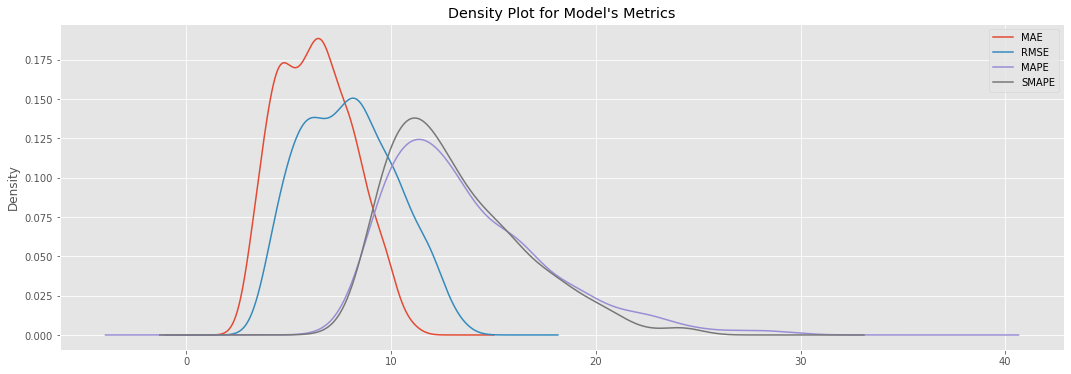

In [19]:
_ = model_metrics.drop(columns='Name').plot.kde(figsize=(18, 6))
plt.title('Density Plot for Model\'s Metrics')
plt.show()